<a href="https://colab.research.google.com/github/mirwisek/frame-selection-activenerf/blob/main/tiny_nerf_pytorch_rizwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **For Rizwan**

## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [1]:
!pip3 install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=edbe56be70f19739e477e0faa4d7f55af1f3de6735606cd3f90a072df9869042
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [2]:

# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from sklearn.decomposition import PCA
import umap


from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [3]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [4]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [5]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [6]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [7]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [8]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## Dataloading utils

In [9]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [10]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-12-05 08:21:33--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-12-05 08:21:33--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  14.4MB/s    in 0.8s    

2023-12-05 08:21:34 (14.4 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



## Determine device to run on (GPU vs CPU)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load up input images, poses, intrinsics, etc.

In [12]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)
testpose = torch.from_numpy(testpose).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)
tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)

#### Display the image used for testing

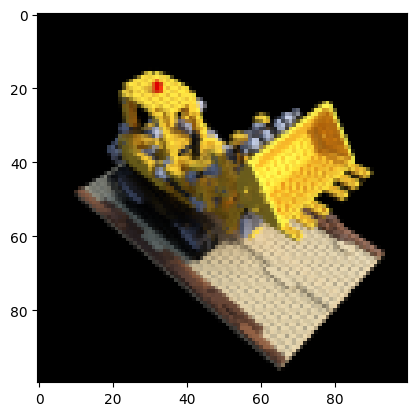

In [13]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## Train TinyNeRF!

(The cool part!)

In [14]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

# **Random Selection of Frames**

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss: 0.16314402222633362


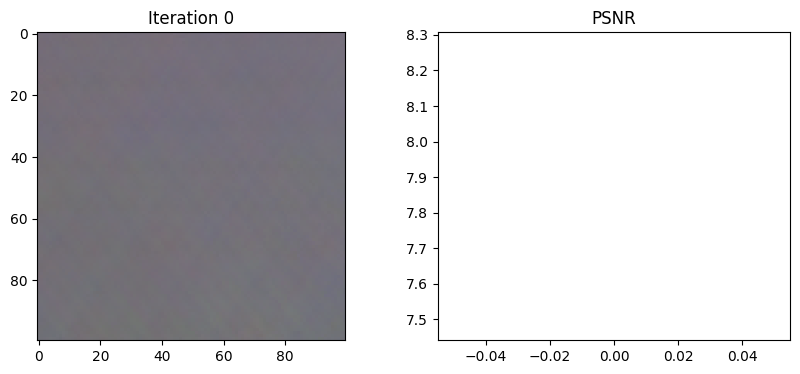

Loss: 0.01213367935270071


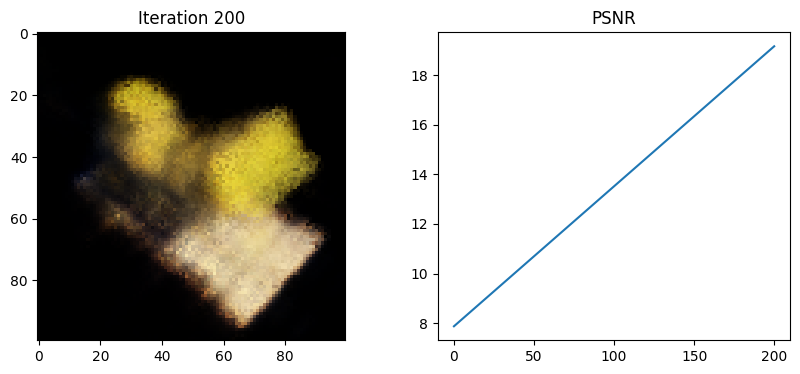

Loss: 0.01025176327675581


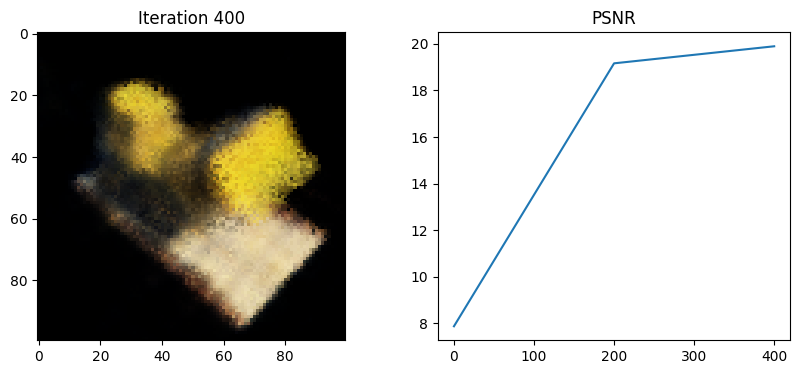

Loss: 0.010788441635668278


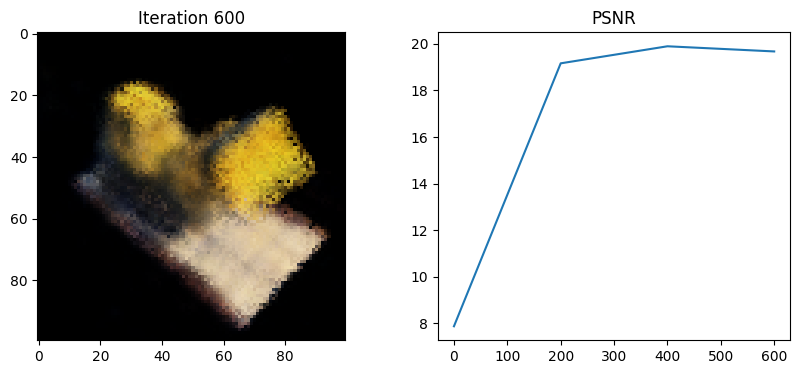

Loss: 0.009951495565474033


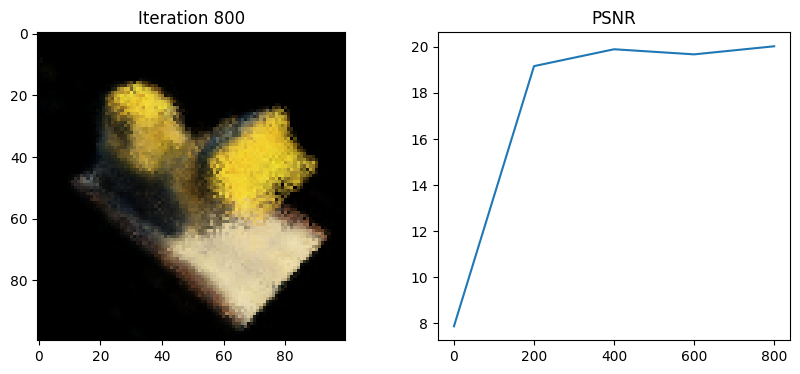

Loss: 0.009408070705831051


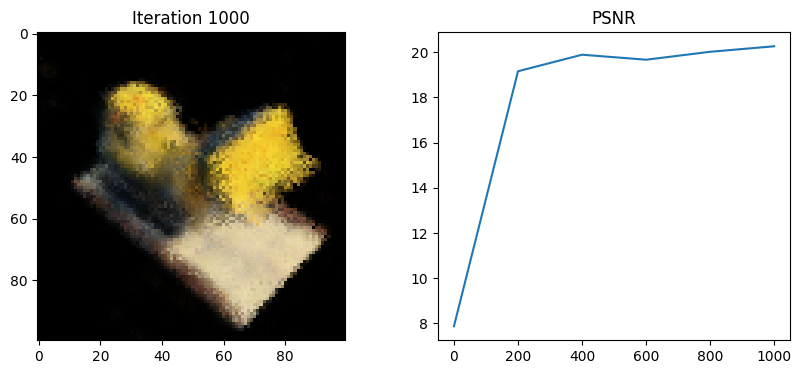

Loss: 0.009765315800905228


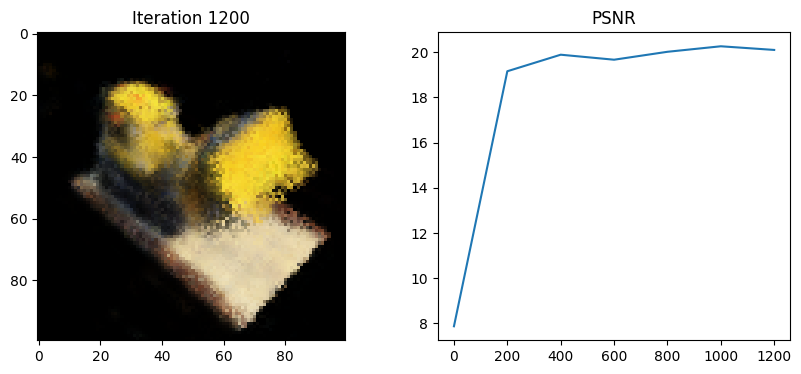

Loss: 0.008939052000641823


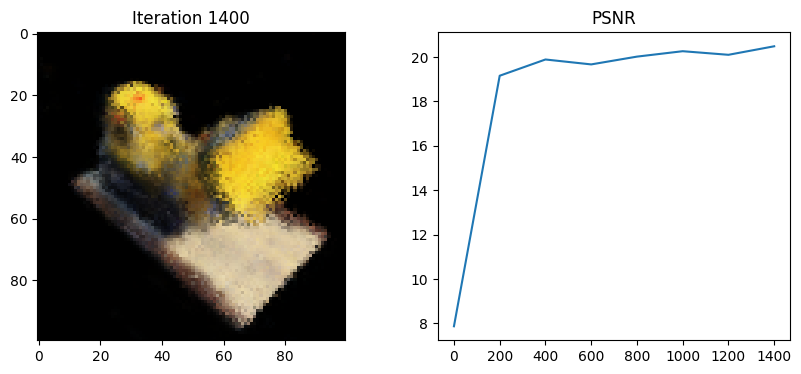

Loss: 0.010942506603896618


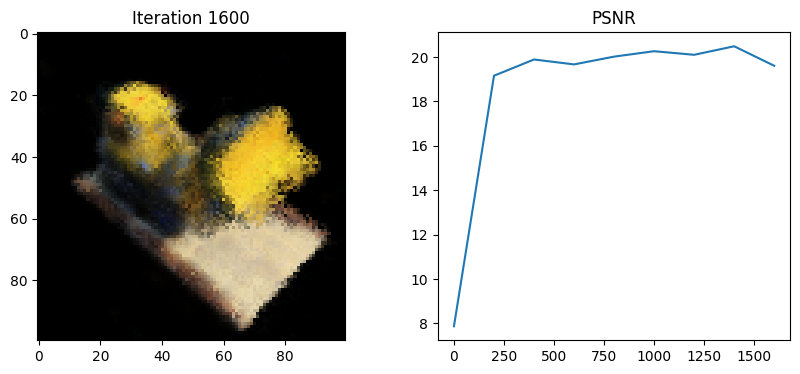

Loss: 0.009672343730926514


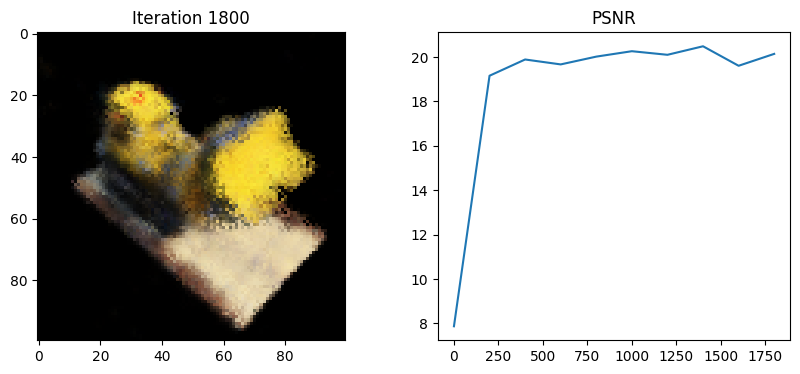

Loss: 0.009536651894450188


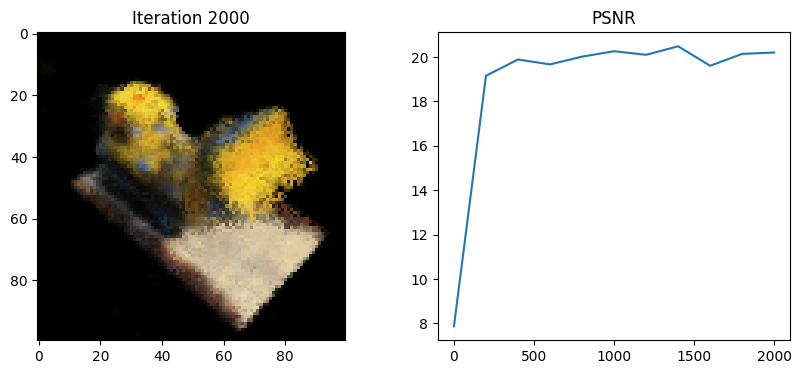

Done!


In [15]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

k = 10

# Shuffle the list of indices randomly
indices = list(range(images.shape[0]))

# Shuffle the list of indices randomly
np.random.shuffle(indices)

# Split the shuffled indices into two parts: k for training and the rest for holdout
training_indices = indices[:k]
holdout_indices = indices[k:]

# Use the indices to split the images into training and holdout arrays
training_images = images[training_indices]
holdout_images = images[holdout_indices]

# Use the indices to split the transformation matrices into training and holdout arrays
training_tforms = tform_cam2world[training_indices]
holdout_tforms = tform_cam2world[holdout_indices]



for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(j)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {j}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()


print('Done!')

In [17]:
rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                        testpose, near_thresh,
                                        far_thresh, depth_samples_per_ray,
                                        encode, get_minibatches)
loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
psnr = -10. * torch.log10(loss)
print("psnr:", psnr.item())

psnr: 20.173051834106445


In [18]:
def camera_position_from_extrinsic_matrix(extrinsic_matrix):
    """
    Calculate the camera position from the extrinsic matrix using PyTorch.

    :param extrinsic_matrix: A 3x4 or 4x4 extrinsic matrix of the camera
    :return: The position of the camera in world coordinates
    """
    # Extract the rotation matrix (R) and the translation vector (t)
    R = extrinsic_matrix[:3, :3]
    t = extrinsic_matrix[:3, 3]

    # Calculate the camera position: C = -R^-1 * t
    camera_position = -torch.inverse(R) @ t
    return camera_position

In [19]:
def furthest_view_sampling_k(train_tform_c2w, holdout_tform_c2w, k):
    # Calculate camera positions for the training set
    training_camera_positions = [camera_position_from_extrinsic_matrix(transform) for transform in train_tform_c2w]

    # Initialize a list to hold the furthest candidates
    furthest_candidates = torch.tensor([]).to(device)

    # Calculate the distance of each candidate to all camera positions in the training set
    for holdout_transform in holdout_tform_c2w:
        holdout_position = camera_position_from_extrinsic_matrix(holdout_transform)

        # Calculate distances to all training set camera positions
        distances = torch.stack([torch.norm(holdout_position - train_pos, p=2) for train_pos in training_camera_positions])

        # Minimum distance to the training set
        min_distance = torch.min(distances)

        # Append the candidate and its minimum distance
        furthest_candidates = torch.cat((furthest_candidates, torch.unsqueeze(min_distance, 0)))

    return torch.argsort(furthest_candidates, descending=True)[:k].tolist()

Loss: 0.17769093811511993


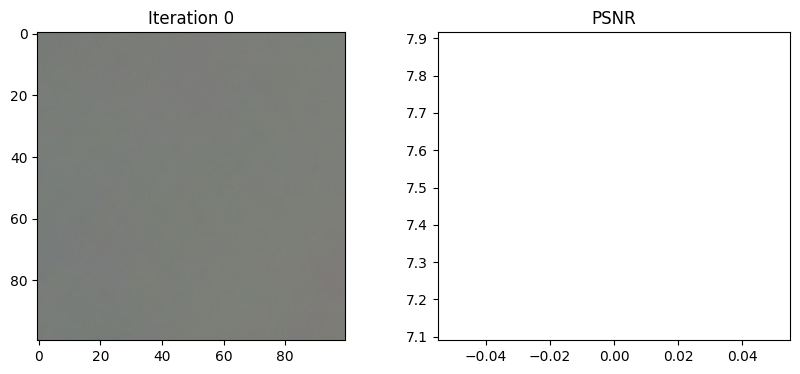

Loss: 0.07613903284072876


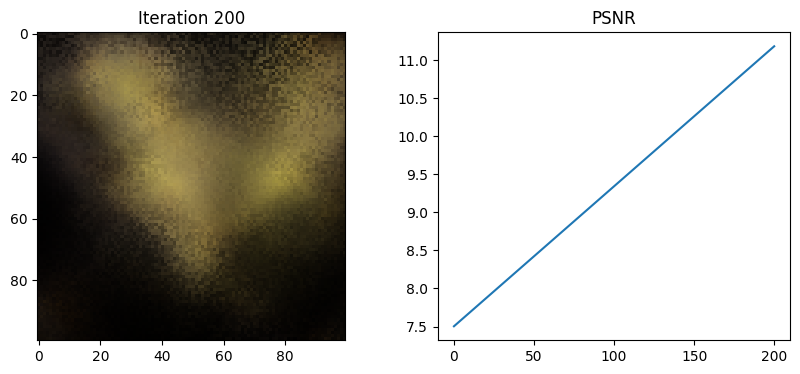

Loss: 0.013463271781802177


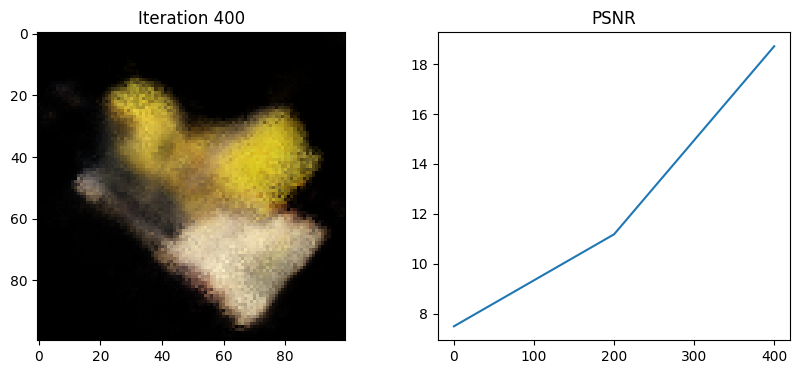

Loss: 0.011435900814831257


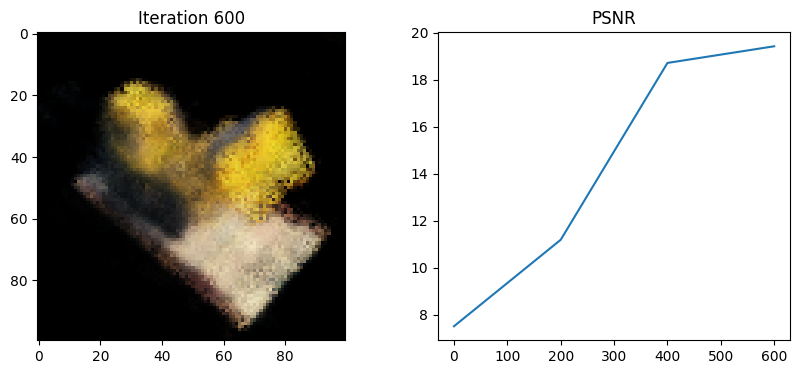

Loss: 0.011041279882192612


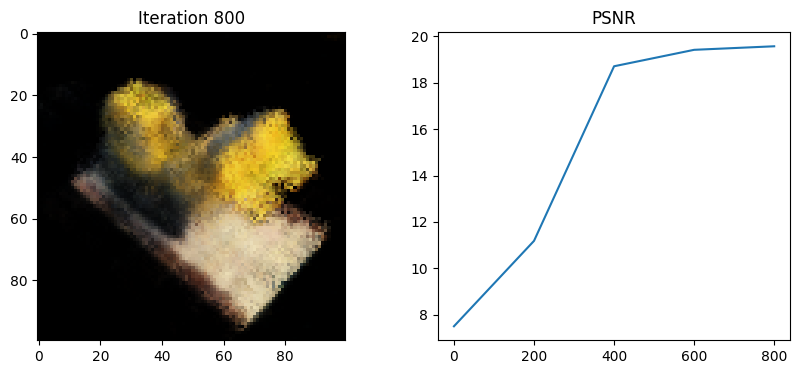

Loss: 0.011818916536867619


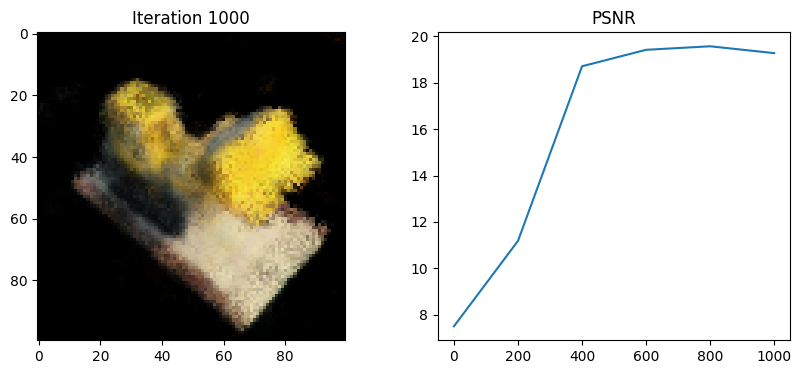

Loss: 0.010883430019021034


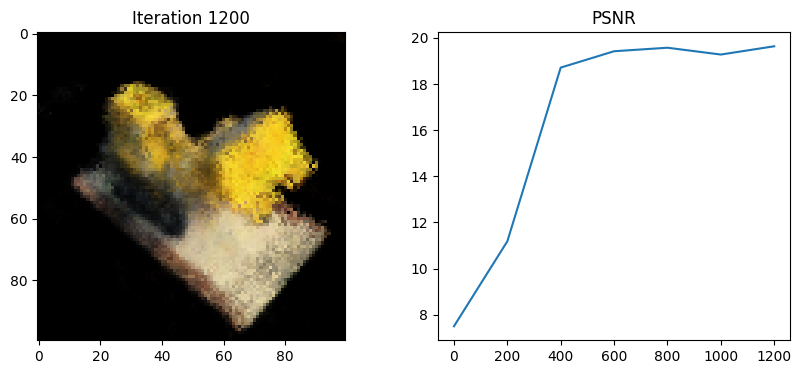

Loss: 0.010638061910867691


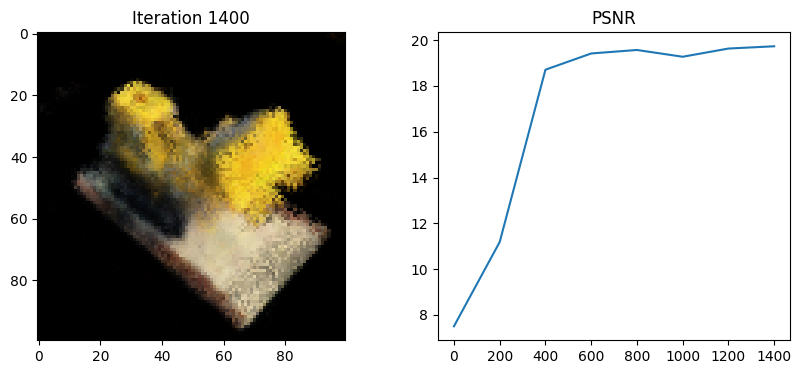

Loss: 0.010541785508394241


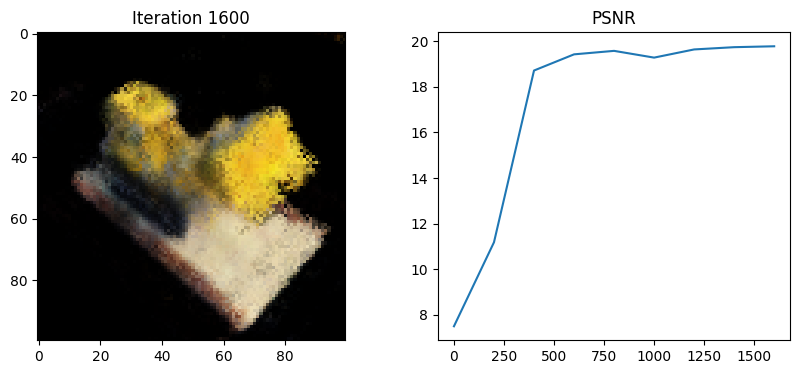

Loss: 0.011004497297108173


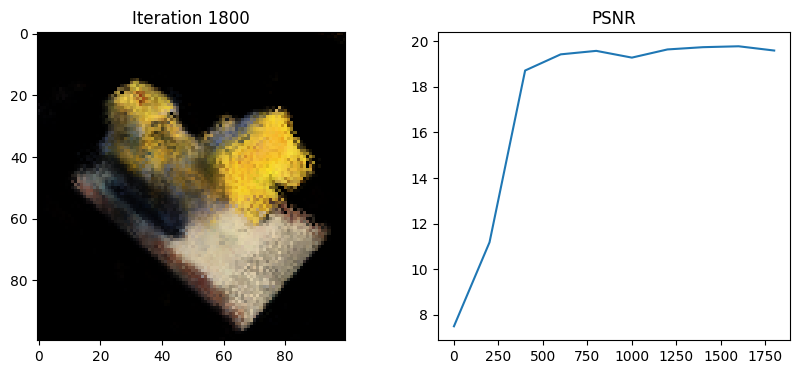

Loss: 0.010380630381405354


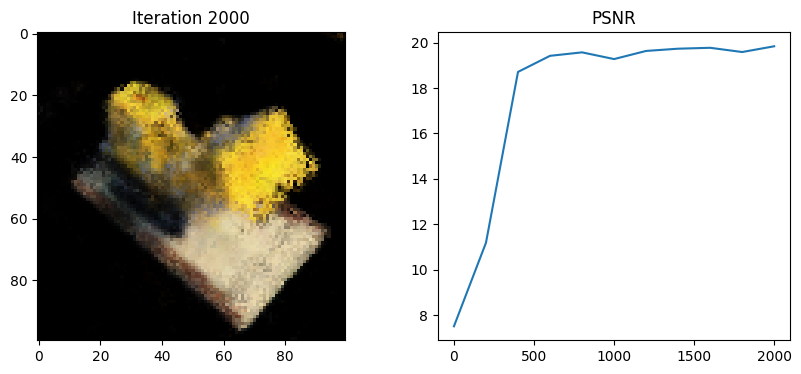

Done!


In [26]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

k = 6

# Shuffle the list of indices randomly
indices = list(range(images.shape[0]))

# Shuffle the list of indices randomly
np.random.shuffle(indices)

# Split the shuffled indices into two parts: k for training and the rest for holdout
training_indices = indices[:4]
holdout_indices = indices[4:]

# Use the indices to split the images into training and holdout arrays
training_images = images[training_indices]
holdout_images = images[holdout_indices]

# Use the indices to split the transformation matrices into training and holdout arrays
training_tforms = tform_cam2world[training_indices]
holdout_tforms = tform_cam2world[holdout_indices]

furthest_view_indices = furthest_view_sampling_k(training_tforms, holdout_tforms, k)
training_images = torch.cat((training_images, holdout_images[furthest_view_indices]))
training_tforms = torch.cat((training_tforms, holdout_tforms[furthest_view_indices]))

holdout_images = torch.stack([holdout_images[i] for i in range(holdout_images.size(0)) if i not in furthest_view_indices])
holdout_tforms = torch.stack([holdout_tforms[i] for i in range(holdout_tforms.size(0)) if i not in furthest_view_indices])


for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(j)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {j}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

In [27]:
rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                        testpose, near_thresh,
                                        far_thresh, depth_samples_per_ray,
                                        encode, get_minibatches)
loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
psnr = -10. * torch.log10(loss)
print("psnr:", psnr.item())

psnr: 19.75489044189453


In [22]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True).to(device)
        self.resnet.eval()

    def forward(self, x):
        # x = x.permute(0, 4, 1, 2, 3)  # Adjust the dimensions to match [batch_size, channels, sequence_length, height, width]
        # x = x.reshape(-1, x.size(2), x.size(3), x.size(4))  # Reshape to [batch_size * sequence_length, height, width, channels]
        x = x.permute(0, 3, 1, 2)  # Adjust the dimensions to match [channels, batch_size, height, width]
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        feats1 = self.resnet.relu(x)
        feats2 = self.resnet.layer1(self.resnet.maxpool(feats1))
        feats3 = self.resnet.layer2(feats2)
        feats4 = self.resnet.layer3(feats3)
        latents = [feats1, feats2, feats3, feats4]
        output_size = (100, 100)
        for i in range(len(latents)):
            latents[i] = F.interpolate(
                latents[i], output_size, mode="bilinear", align_corners=True
            )
        latents = torch.cat(latents, dim=1)
        return latents

In [23]:
def numpy_cosine(img1, img2):
  e1 = np.expand_dims(img1, axis=0)
  e2 = np.expand_dims(img2, axis=0)
  return 1 - cosine_similarity(e1, e2)

def extract_features(image_array):
  # Instantiate the ImageEncoder
  image_encoder = ImageEncoder()

  # Get the embeddings
  embeddings = image_encoder(image_array)

  # Perform PCA for dimensionality reduction
  #  pca = PCA(n_components=10)

  image_embd = embeddings.squeeze().contiguous().view(embeddings.size(0), -1).cpu().detach().numpy()

  pca = PCA(n_components=50)
  reduced_img_embd = pca.fit_transform(image_embd)
  scaler = StandardScaler()
  scaled_red_img_emb = scaler.fit_transform(reduced_img_embd)

  return scaled_red_img_emb


def perform_dbscan_clustering(features, eps=0.5, min_samples=5, metric = "euclidean"):
    """
    Perform DBSCAN clustering on the given features.
    """
    return DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit_predict(features)

def euclidean_distance(vec1, vec2):
    np.linalg.norm
    return np.linalg.norm(vec1 - vec2, ord=2)

def select_diverse_images_per_cluster(embeddings, labels):
    """
    Select the most diverse image from each cluster based on cosine similarity.
    """
    unique_labels = set(labels)
    selected_indices = []

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise

        cluster_indices = [i for i, lbl in enumerate(labels) if lbl == label]

        if len(cluster_indices) > 1:
            # Calculate pairwise cosine similarity and select the image with the lowest average similarity
            cluster_embeddings = np.array([embeddings[i] for i in cluster_indices])
            centroid = np.mean(cluster_embeddings,  axis=0)

            closest_image_index = None
            min_distance = float('inf')

            for i, embd in zip(cluster_indices, cluster_embeddings):
              distance = euclidean_distance(embd, centroid)
              if distance < min_distance:
                  min_distance = distance
                  closest_image_index = i

            selected_indices.append(closest_image_index)

        else:
            selected_indices.append(cluster_indices[0])

    return selected_indices

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


Loss: 0.15932779014110565


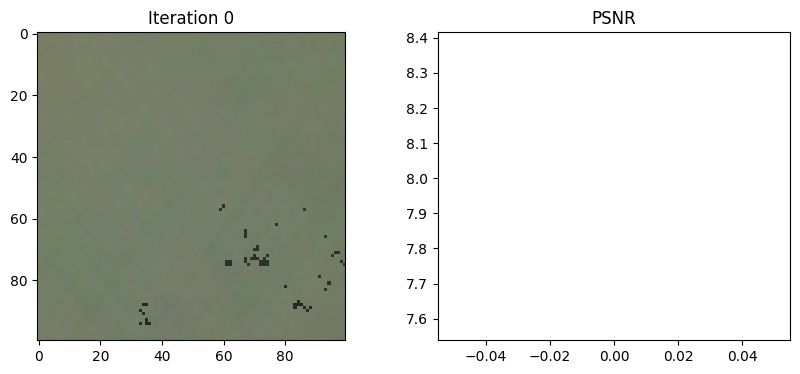

Loss: 0.01542629487812519


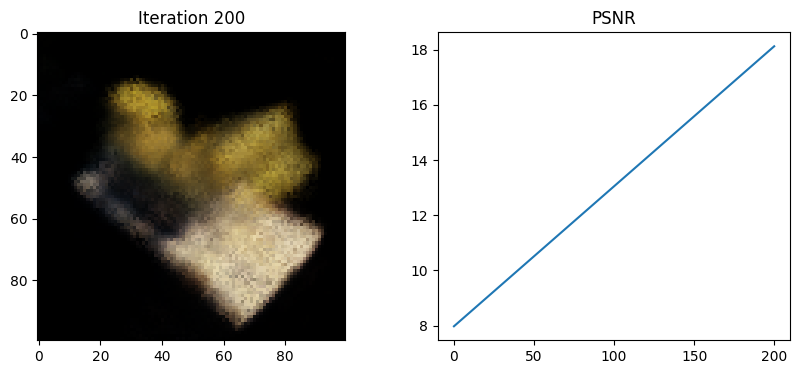

Loss: 0.012384191155433655


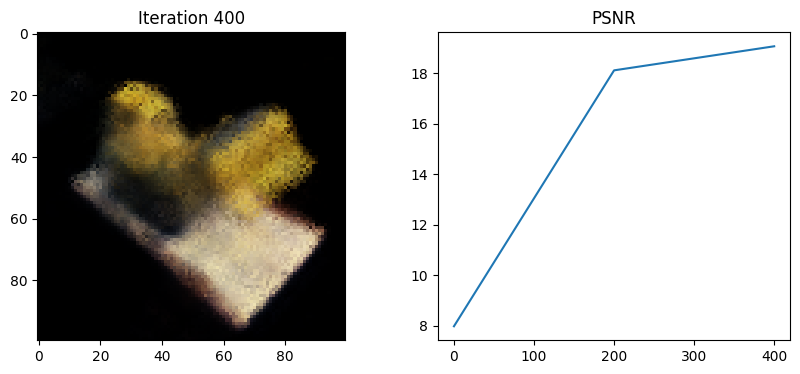

Loss: 0.00887146033346653


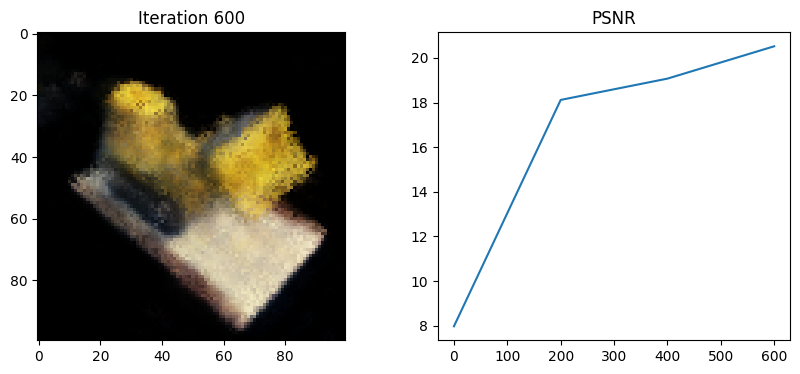

Loss: 0.010117704048752785


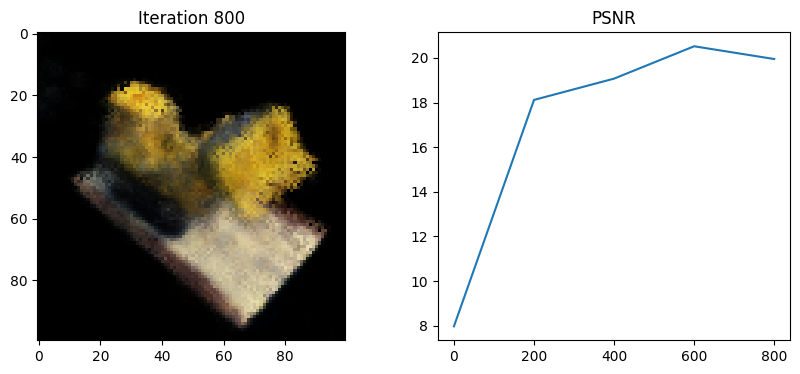

Loss: 0.007721791509538889


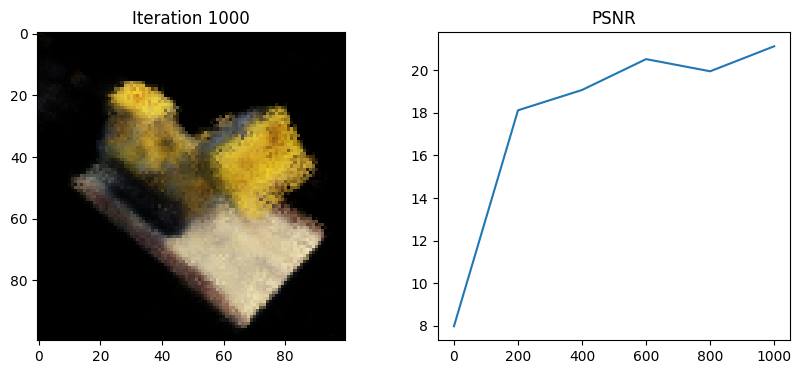

Loss: 0.008256427943706512


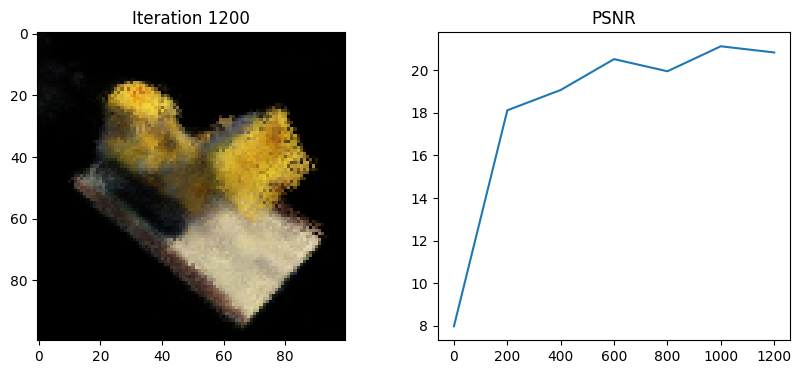

Loss: 0.008581344038248062


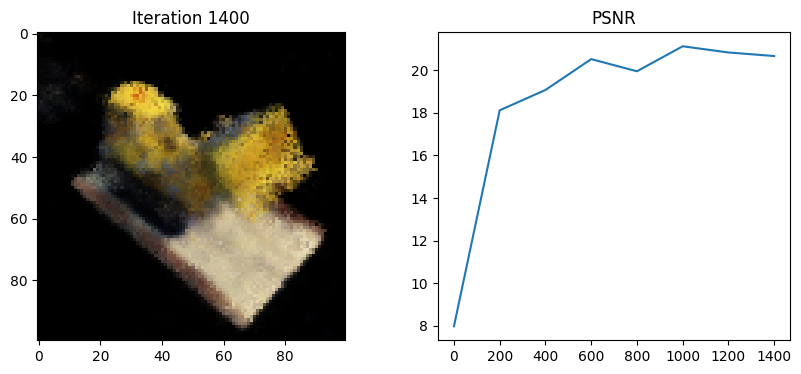

Loss: 0.007814022712409496


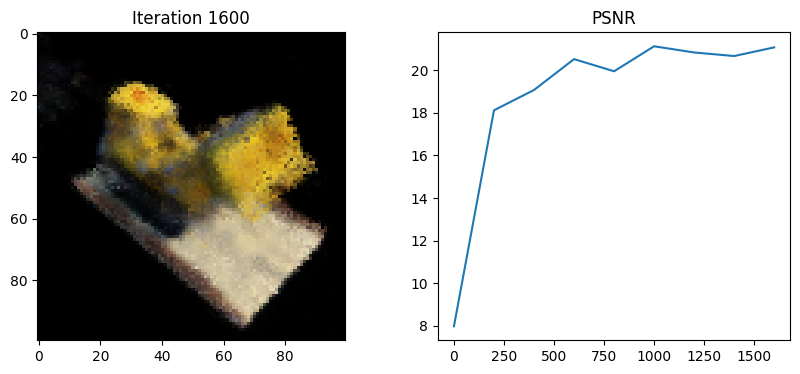

Loss: 0.0073888967745006084


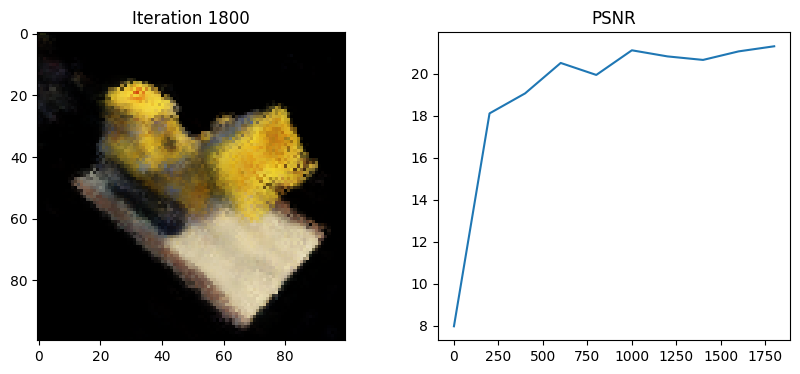

Loss: 0.007582194171845913


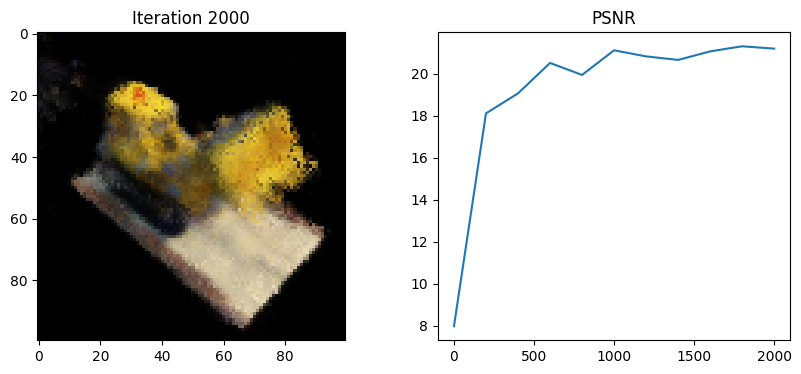

Done!


In [24]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

embeddings = extract_features(images)
labels = perform_dbscan_clustering(embeddings, eps=0.4, min_samples=3, metric = numpy_cosine)
diverse_indices = select_diverse_images_per_cluster(embeddings, labels)

training_images = images[diverse_indices]
training_tforms = tform_cam2world[diverse_indices]

for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(j)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {j}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

In [25]:
rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                        testpose, near_thresh,
                                        far_thresh, depth_samples_per_ray,
                                        encode, get_minibatches)
loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
psnr = -10. * torch.log10(loss)
print("psnr:", psnr.item())

psnr: 21.229759216308594
